In [142]:
import sys,os

import pyglet
pyglet.options['shadow_window'] = True

import pyrender#to display mesh
import numpy as np
import trimesh#to load mesh

import matplotlib
import matplotlib.pyplot as plt
import igl

from sklearn.neighbors import KDTree
from ICP_functions import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
#Make obj files for each model.
obj_filenames=['bunny_v2/bun000_v2.obj','bunny_v2/bun045_v2.obj','bunny_v2/bun315_v2.obj',
              'bunny_v2/bun090_v2.obj','bunny_v2/bun180_v2.obj','bunny_v2/bun270_v2.obj']
make_obj_test_files(obj_filenames)
n_models=len(obj_filenames)

In [144]:
start_m_index=1
joining_m_indices=[2,3,4,5,6]

all_m_indices=joining_m_indices.copy()
all_m_indices.reverse()
all_m_indices.append(start_m_index)
all_m_indices.reverse()


In [145]:
colors=[(0.0,0.0,1.0),(0.0,1.0,0.0),(1.0,0.0,0.0),(0.0,1.0,1.0),(1.0,0.0,1.0),(1.0,1.0,0.0)]
mesh_rds=[]
for i in all_m_indices:
    fp="M"+str(i)+".obj"
    tm = trimesh.load_mesh(fp)#load mesh
    surface_points = tm.sample(50000)#sample points for a point cloud
        
    mesh_rd = pyrender.Mesh.from_points(surface_points, colors[i-1])#make a point cloud object
    mesh_rds.append(mesh_rd)

show_mesh_gui(mesh_rds[:6])#Display all point clouds

In [151]:

P, f_P = igl.read_triangle_mesh('M'+str(start_m_index)+'.obj')
print('Starting with model M'+str(start_m_index)+'.')

experiment_mses=[]
iterations_used=[]
rotations=[]
translations=[]
aligned_vs=[]
aligned_fs=[]

for i in joining_m_indices:#the M numbers of the models to add
    
    print('Registering model M'+str(i)+'... ',end='')
    
    Q, f_Q = igl.read_triangle_mesh("M"+str(i)+".obj")
    
    
    if i in [1,2,3]:
        #R,t,mse_losses,iterations=ICP_with_PCA_initial_rotation(P,Q)
        R,t,mse_losses,iterations=ICP(P,Q)
    else:
        print('Trying ICP with several different initial orientations.')
        R,t,mse_losses,iterations=ICP_with_initial_rotation(P,Q)
    
    rotations.append(R)
    translations.append(t)
    experiment_mses.append(mse_losses)
    iterations_used.append(iterations)
    
    #Join aligned model to the combined model.
    aligned_Q = (R@Q.T).T + t.T
    aligned_vs.append(aligned_Q)
    aligned_fs.append(f_Q)
    
    P = np.vstack((P,aligned_Q))
    f_P = np.vstack((f_P,f_Q + P.shape[0]))

Starting with model M1.
Registering model M2... ICP converged after 32 iterations.
Registering model M3... ICP converged after 61 iterations.
Registering model M4... Trying ICP with several different initial orientations.
ICP converged after 63 iterations.
ICP did not converge after 100 iterations.
ICP converged after 42 iterations.
ICP converged after 97 iterations.
ICP converged after 33 iterations.
ICP converged after 37 iterations.
ICP converged after 32 iterations.
ICP converged after 36 iterations.
ICP converged after 32 iterations.
Registering model M5... Trying ICP with several different initial orientations.
ICP converged after 40 iterations.
ICP converged after 64 iterations.
ICP did not converge after 100 iterations.
ICP converged after 71 iterations.
ICP did not converge after 100 iterations.
ICP converged after 81 iterations.
ICP converged after 21 iterations.
ICP converged after 74 iterations.
ICP did not converge after 100 iterations.
Registering model M6... Trying ICP w

In [153]:
aligned_rds=[mesh_rds[0]]
j=0
for i in joining_m_indices:
    ret=igl.write_triangle_mesh("M_aligned"+str(i)+".obj", aligned_vs[j],aligned_fs[j])
    fp="M_aligned"+str(i)+".obj"
    tm = trimesh.load_mesh(fp)#load mesh
    surface_points = tm.sample(20000)#sample points for a point cloud
    mesh_rd = pyrender.Mesh.from_points(surface_points, colors=colors[i-1])#make a point cloud object
    aligned_rds.append(mesh_rd)
    j+=1
show_mesh_gui(aligned_rds[:6])#Display mesh or pointcloud.

In [46]:
print(np.linalg.eig(P.T@P))

(array([2538.95819107,  433.85284079,  280.12821595]), array([[-0.02860221,  0.91838779,  0.3946464 ],
       [ 0.21380998, -0.3800496 ,  0.89991533],
       [-0.97645645, -0.11011891,  0.18549022]]))


IndexError: list index out of range

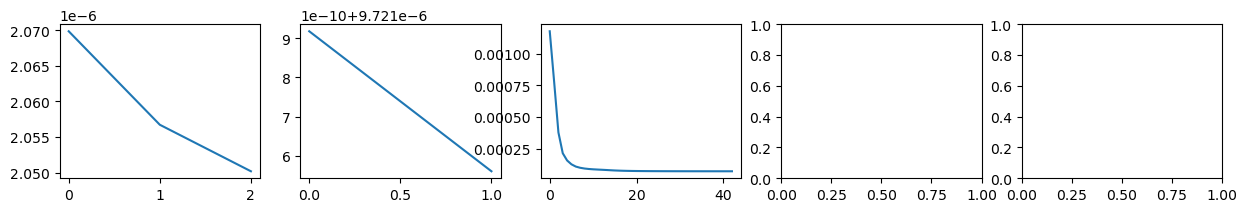

In [14]:
fig,ax=plt.subplots(1,5,figsize=(15,2))
for i in range(0,6):
    ax[i].plot(experiment_mses[i])
plt.show()

In [30]:
ret=igl.write_triangle_mesh("combination.obj", P,f_P)
fp="combination.obj"
tm = trimesh.load_mesh(fp)#load mesh
surface_points = tm.sample(10000)#sample points for a point cloud
mesh_rd = pyrender.Mesh.from_points(surface_points, colors=(1.0,0.3,0.0))#make a point cloud object


show_mesh_gui([mesh_rd])#Display mesh or pointcloud.

IndexError: index 218020 is out of bounds for axis 0 with size 218020

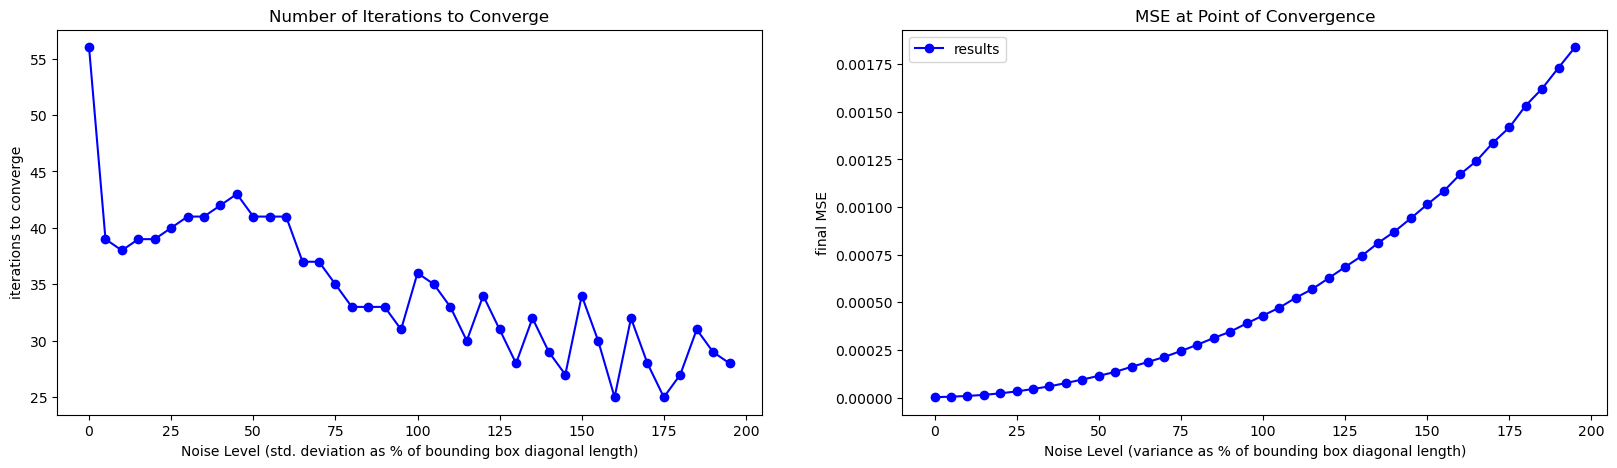

In [242]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
noise_levels=np.array([5*i for i in range(0,n)])#that is std. deviation of gaussian, as a % of bb diagonal length

final_mses = [experiment_mses[i][-1] for i in range(0,n)]
ax[0].plot(noise_levels,iterations_used,'bo-')
ax[0].set_xlabel('Noise Level (std. deviation as % of bounding box diagonal length)')
ax[0].set_ylabel('iterations to converge')
ax[0].set_title('Number of Iterations to Converge')


ax[1].plot(noise_levels,final_mses,'bo-')

#degree=3
#coeffs=np.polyfit(noise_levels**2,final_mses,degree)
#polynomial3=np.sum([coeffs[i]*noise_levels**(2*i) for i in range(degree+1)],axis=0)
#ax[1].plot(noise_levels**2,polynomial3,'r-')

ax[1].legend(['results','fitted cubic'])
ax[1].set_xlabel('Noise Level (variance as % of bounding box diagonal length)')
ax[1].set_ylabel('final MSE')
ax[1].set_title('MSE at Point of Convergence')
plt.show()